# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import ActorCriticNetwork, ReplayMemory

In [13]:
R = np.array([4, 1, 6, 7, 9], dtype=np.float32)
V = np.array([-1, -2, 1, 4, -5], dtype=np.float32)

In [3]:
def shift_vector(vec, pos=1):
    vec_ = np.concatenate((vec, np.zeros(pos)))
    return vec_[pos:]

def calc_targets(rewards, values, depth, gamma):
    r = np.array(rewards, dtype=np.float32).ravel()
    v = np.array(values, dtype=np.float32).ravel()
    targets = np.zeros_like(r)
    for i in range(depth):
        targets += (gamma ** i) * shift_vector(r, i)
    targets += (gamma ** depth) * shift_vector(v, depth)
    return targets.reshape(-1, 1)

# Snake class

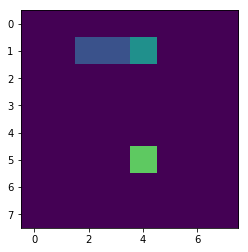

In [3]:
s = Snake()
img = s.reset()
s.plot_state()

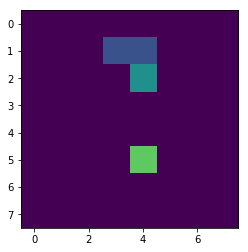

In [4]:
img, r, done = s.step(2)
s.plot_state()

# NN training

In [8]:
class SnakeAgent:
    
    def __init__(self, model_name="baseline_agent"):
        
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.train_env = Snake()
        self.num_actions = 4
            
        self.path = "snake_models" + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = ActorCriticNetwork(self.num_actions, scope="agent")
        self.target_net = ActorCriticNetwork(self.num_actions, scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.1,
                       annealing_steps=100000,
                       discount_factor=0.99,
                       n_step=3,
                       max_episode_length=2000):
        
        # create experience replay and fill it with random policy samples
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end = self.train_env.step(a)
                self.rep_buffer.push(s, a, np.sign(r), s_, end)
                s = s_
                frame_count += 1
                if end:
                    break
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        self.n_step = n_step
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              max_num_episodes=100000,
              max_num_epochs=50000,
              performance_print_freq=100,
              save_freq=10000):
        
        target_ops = self.update_target_graph(tau)
        
        with tf.Session() as sess:
            sess.run(self.init)
            
            train_rewards = []
            PG_loss, VAL_loss = [], []
            frame_count = 0
            episode_count = 0
            num_epochs = 0
            
            while num_epochs < max_num_epochs:
                
                train_ep_reward = 0
                
                # reset the environment / start new game
                s = self.train_env.reset()
                
                states = []
                actions = []
                rewards = []
                
                for time_step in range(self.max_ep_length):
                    
                    act_probs = self.agent_net.get_probs(sess, [s])
                    a = np.random.choice(self.num_actions, p=act_probs.ravel())
                    states.append(s)
                    actions.append(a)
                    # make step in the environment
                    s, r, end = self.train_env.step(a)
                    rewards.append(r)

                    # update current state and statistics
                    frame_count += 1
                    train_ep_reward += r
                    
                    # make checkpoints of network weights and save learning curve
                    if frame_count % save_freq == 1:
                        num_epochs += 1
                        try:
                            self.saver.save(sess, self.path+"/model", global_step=num_epochs)
                            np.savez(self.path+"/learning_curve.npz", r=train_rewards)
                        except:
                            pass
                        
                    if end: break
                
                values = self.agent_net.get_values(sess, states)
                targets = calc_targets(rewards, values, self.n_step, self.gamma)
                pg_targets = targets - values
                  
                # update network weights
                
                pg_loss, val_loss = self.agent_net.update(sess, states, actions, pg_targets, targets)
                PG_loss.append(pg_loss)
                VAL_loss.append(val_loss)
                         
                episode_count += 1
                train_rewards.append(train_ep_reward)
                
                # print performance once in a while
                if episode_count % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    avg_pg_loss = np.mean(PG_loss[-performance_print_freq:])
                    avg_val_loss = np.mean(VAL_loss[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, avg_pg_loss, avg_val_loss)  

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

In [9]:
aa = SnakeAgent(model_name="test2")

In [10]:
aa.set_parameters(max_episode_length=1000, replay_memory_size=50000, replay_start_size=10000)

In [ ]:
aa.train(gpu_id=0)

Train info: 777 -0.87 -21.4547 0.240491
Train info: 1543 -0.92 -16.298 0.153546
Train info: 2459 -0.87 -4.83338 0.0798858
Train info: 3274 -0.92 -0.0808705 0.0443214
Train info: 4101 -0.86 7.83107 0.0390468
Train info: 4857 -0.9 4.32984 0.0273029
Train info: 5626 -0.89 7.51827 0.028144
Train info: 6425 -0.9 6.78224 0.0240741
Train info: 7243 -0.88 5.03037 0.0277286
Train info: 8133 -0.89 5.31946 0.0325434
Train info: 8920 -0.94 0.517994 0.0202131
Train info: 9782 -0.92 5.53896 0.0201518
Train info: 10650 -0.82 7.96302 0.0324679
Train info: 11531 -0.86 5.49608 0.0273787
Train info: 12313 -0.92 4.79561 0.0148475
Train info: 13117 -0.93 4.66935 0.0132647
Train info: 13909 -0.91 9.58051 0.0154501
Train info: 14734 -0.87 6.26124 0.0224615
Train info: 15574 -0.9 4.14778 0.0195258
Train info: 16438 -0.92 3.73967 0.0165844
Train info: 17283 -0.89 4.78244 0.0182421
Train info: 18106 -0.84 6.12342 0.0308484
Train info: 18925 -0.84 6.74261 0.0261258
Train info: 19724 -0.9 5.0197 0.0214938
Train i

# Visualization

In [20]:
tf.reset_default_graph()
agent_net = PGNetwork(4, scope="agent")
saver = tf.train.Saver()
env = Snake()

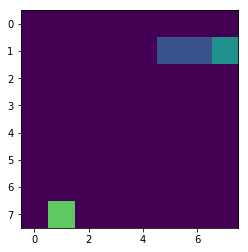

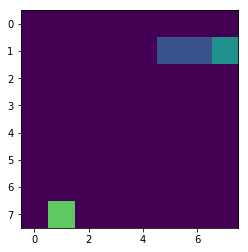

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "snake_models/test/model-55")
    s = env.reset()
    for i in range(20):
        probs = agent_net.get_probs(sess, [s])
        a = agent_net.get_p_argmax(sess, [s])[0]
        s, r, done = env.step(a)
        
        
        env.plot_state()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        
        if done: break

In [26]:
probs

array([[ 0.06805254,  0.69527936,  0.05574758,  0.18092045]], dtype=float32)